In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from copy import deepcopy
import pickle as pkl

from ex_cosmology import p
from matplotlib import gridspec
import matplotlib.patches as mpatches

# adaptive-wavelets modules
import awave
from awave.data.cosmology import get_dataloader, load_pretrained_model
from awave.data.cosmology import get_validation
from awave.utils.misc import tuple_to_tensor, get_2dfilts
from awave.trim import TrimModel
from umap import UMAP
from sklearn.decomposition import PCA

# evaluation
from eval_cosmology import load_results, rmse_bootstrap, extract_patches
from peak_counting import PeakCount

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dirs = [
    "db5_saliency_warmstart_seed=1_new"
]
dics, results, models = load_results(dirs)

In [3]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path,
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size)

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)

# validation dataset
test_loader = get_validation(p.data_path,
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

In [5]:
# # DB5
wt_o = awave.DWT2d(wave='db5', mode='zero', J=4,
                               init_factor=1, noise_factor=0, const_factor=0)

# # extract kernels
# kern_list = []
# for wt in [wt_o] + list(dics[0]['wt'].values()):
#     filt = adaptive_wavelets.get_2dfilts(wt)
#     h = filt[0][0]
#     g = filt[0][1]
#     kern_list.append(extract_patches(h, g))

bds = np.linspace(0.015, 0.035, 5)
# scores = np.zeros((len(bds), len(kern_list)))  

# for i,b in enumerate(bds):
#     for j,kernels in enumerate(kern_list):
#         pcw = PeakCount(peak_counting_method='custom', 
#                         bins=np.linspace(0,b,23),
#                         kernels=kernels)
#         pcw.fit(train_loader)
#         y_preds, y_params = pcw.predict(val_loader)
#         scores[i,j] = rmse(y_params, y_preds)
#         pkl.dump(scores, open('results/scores_new.pkl', 'wb'))  
#         print(
#             "\riteration bd={}/{} kern={}/{}".format(
#                 i + 1, len(bds), j + 1, len(kern_list)
#             ),
#             end="",
#         )        

# print('\n', np.min(scores))

# optimal filter

In [9]:
# load optimal wavelet for prediction on heldout dataset
scores = pkl.load(open('results/scores_new.pkl', 'rb'))
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dics[0]['wt'].keys())[col + 1]  ## NEED TO CHECK
# idx2 = 4
wt = dics[0]['wt'][(idx1, idx2)]
lamL1wave = dics[0]['lamL1wave'][(idx1, idx2)]
lamL1attr = dics[0]['lamL1attr'][(idx1, idx2)]
print('lambda: {} gamma: {}'.format(lamL1wave, lamL1attr))

# AWD prediction performance
filt = get_2dfilts(wt)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw1 = PeakCount(peak_counting_method='custom',
                bins=np.linspace(0, bd_opt, 23),
                kernels=kernels)
pcw1.fit(test_loader)

# original wavelet prediction performance
filt = get_2dfilts(wt_o)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw2 = PeakCount(peak_counting_method='custom',
                bins=np.linspace(0, bds[np.argmin(scores[:, 0])], 23),
                kernels=kernels)
pcw2.fit(test_loader)

lambda: 0.02 gamma: 0.00368


In [45]:
keys = list(pcw1.peak_list.keys())
X1 = []
X2 = []
for k in keys:
    a = pcw1.peak_list[k]
    b = pcw2.peak_list[k]
    X1 += a
    X2 += b
X1 = np.stack(X1, axis=0)
X2 = np.stack(X2, axis=0)

# PCA

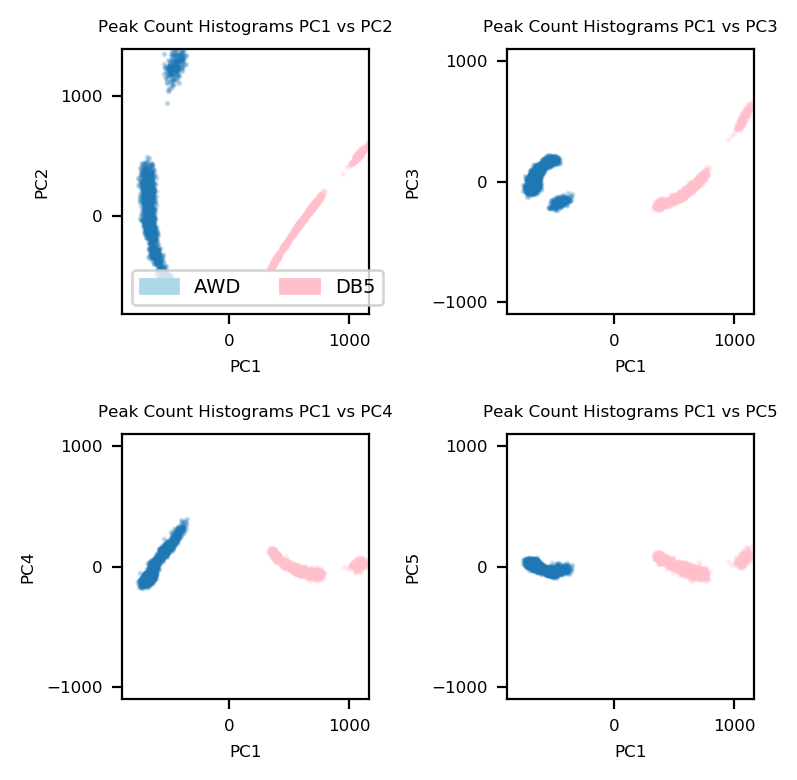

In [71]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['pink', 'lightblue']
n = 2000

# run pca
pca = PCA(n_components=6)
d = np.concatenate((X1,X2), axis=0)
embedding = pca.fit_transform(d)

# embedding1 vs embedding2
f_ax1 = fig.add_subplot(spec[0, 0])

h1 = plt.scatter(embedding[:n, 0], embedding[:n, 1], marker=".", s=5, alpha=0.2) #, cmap='Blues')
h2 = plt.scatter(embedding[n:, 0], embedding[n:, 1], marker=".", s=5, c='pink', alpha=0.2) #y_test, cmap='Reds')  
plt.gca().set_aspect('equal', 'datalim')
blue_patch = mpatches.Patch(color='lightblue', label='AWD')
red_patch = mpatches.Patch(color='pink', label='DB5')
plt.legend((h1, h2),
           ('AWD', 'DB5'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=7,
           handles=(blue_patch, red_patch))
plt.title("Peak Count Histograms PC1 vs PC2", fontsize=6)
plt.xticks([-1000, 0, 1000], fontsize=6)
plt.yticks([-1000, 0, 1000], fontsize=6)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC2', fontsize=6)

# embedding1 vs embedding2
f_ax2 = fig.add_subplot(spec[0, 1])

b1 = plt.scatter(embedding[:n, 0], embedding[:n, 2], marker=".", s=5, alpha=0.2) #, cmap='Blues')
b2 = plt.scatter(embedding[n:, 0], embedding[n:, 2], marker=".", s=5, c='pink', alpha=0.2) #y_test, cmap='Reds')  
plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Peak Count Histograms PC1 vs PC3", fontsize=6)
plt.xticks([-1000, 0, 1000], fontsize=6)
plt.yticks([-1000, 0, 1000], fontsize=6)
# plt.colorbar(b1)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC3', fontsize=6)

# embedding1 vs embedding2
f_ax3 = fig.add_subplot(spec[1, 0])

plt.scatter(embedding[:n, 0], embedding[:n, 3], marker=".", s=5, alpha=0.2) #, cmap='Blues')
plt.scatter(embedding[n:, 0], embedding[n:, 3], marker=".", s=5, c='pink', alpha=0.2) #y_test, cmap='Reds')  
plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Peak Count Histograms PC1 vs PC4", fontsize=6)
plt.xticks([-1000, 0, 1000], fontsize=6)
plt.yticks([-1000, 0, 1000], fontsize=6)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC4', fontsize=6)

# embedding1 vs embedding2
f_ax4 = fig.add_subplot(spec[1, 1])

r1 = plt.scatter(embedding[:n, 0], embedding[:n, 4], marker=".", s=5, alpha=0.2) #, cmap='Blues')
r2 = plt.scatter(embedding[n:, 0], embedding[n:, 4], marker=".", s=5, c='pink', alpha=0.2) #y_test, cmap='Reds')  
plt.gca().set_aspect('equal', 'datalim')
plt.title("Peak Count Histograms PC1 vs PC5", fontsize=6)
plt.xticks([-1000, 0, 1000], fontsize=6)
plt.yticks([-1000, 0, 1000], fontsize=6)
# plt.colorbar(r2)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC5', fontsize=6)
plt.tight_layout()
plt.show()

In [72]:
# run pca
pcas = []
pcas_db5 = []
for idx in range(4):
    pca = PCA(n_components=10)
    pca.fit_transform(X1)
    pcas.append(deepcopy(pca))
    
    pca = PCA(n_components=10)
    pca.fit_transform(X2)
    pcas_db5.append(deepcopy(pca))
    
#     embedding = pca.fit_transform(d)

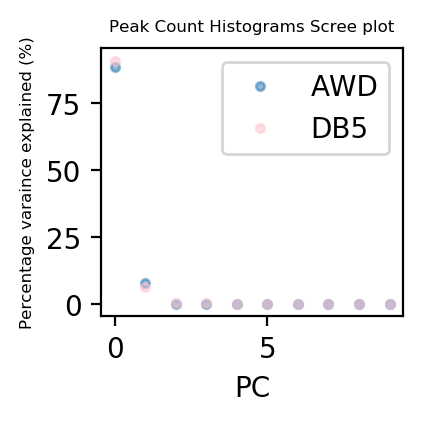

In [73]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(2,2))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
n = 2000

# plot 1
f_ax1 = fig.add_subplot(spec[0, 0])


plt.plot(pcas[0].explained_variance_ratio_*100, ".", alpha=.5, label='AWD')
plt.plot(pcas_db5[0].explained_variance_ratio_*100, ".", color="pink", alpha=.5, label='DB5')
plt.xlabel("PC")
plt.ylabel("Percentage varaince explained (%)", fontsize=6)
plt.title("Peak Count Histograms Scree plot", fontsize=6)
plt.legend()

plt.show()